## Import libraries

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import plot_importance

## Read the CICIDS2017 dataset

In [22]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017.csv')

In [23]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [24]:
df.Label.value_counts()

BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

### Data sampling
Due to the space limit of GitHub files, we sample a small-sized subset for model learning using random sampling

In [25]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [26]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [27]:
df_s = df_s.sort_index()

In [28]:
# Save the sampled dataset
df_s.to_csv('./data/CICIDS2017_sample.csv',index=0)

### Preprocessing (normalization and padding values)

In [29]:
df = pd.read_csv('./data/CICIDS2017_sample.csv')

In [30]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [31]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [32]:
X_train.shape

(5048, 77)

In [33]:
pd.Series(y_train).value_counts()

6    1744
1    1573
3     761
2     442
5     317
0     182
4      29
dtype: int64

### Oversampling by SMOTE

In [34]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"

In [35]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [36]:
pd.Series(y_train).value_counts()

6    1744
1    1573
4    1500
3     761
2     442
5     317
0     182
dtype: int64

## Machine learning model training

Accuracy of XGBoost: 0.9881235154394299
Precision of XGBoost: 0.9882175680509848
Recall of XGBoost: 0.9881235154394299
F1-score of XGBoost: 0.9881050266783028
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        45
           1       1.00      0.99      1.00       393
           2       0.99      1.00      1.00       111
           3       0.98      0.98      0.98       191
           4       0.62      0.71      0.67         7
           5       1.00      1.00      1.00        80
           6       0.99      1.00      1.00       436

    accuracy                           0.99      1263
   macro avg       0.93      0.93      0.93      1263
weighted avg       0.99      0.99      0.99      1263



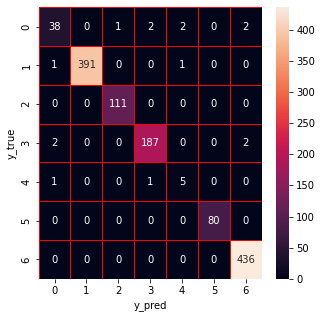

In [37]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10, eval_metric='mlogloss')
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [38]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)